In [14]:
import math
import argparse
import numpy as np
from PIL import Image
from torchvision import datasets
from torchvision import transforms

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)
normal_mean = (0.5, 0.5, 0.5)
normal_std = (0.5, 0.5, 0.5)

In [15]:
def get_config():
    parser = argparse.ArgumentParser(description='PyTorch FixMatch Training')
    parser.add_argument('--gpu-id', default='0', type=int, help='id(s) for CUDA_VISIBLE_DEVICES')
    parser.add_argument('--num-workers', type=int, default=4, help='number of workers')
    parser.add_argument('--dataset', default='cifar10', type=str, choices=['cifar10', 'cifar100'], help='dataset name')
    parser.add_argument('--num-labeled', type=int, default=4000, help='number of labeled data')
    parser.add_argument("--expand-labels", action="store_true", help="expand labels to fit eval steps")
    parser.add_argument('--arch', default='wideresnet', type=str, choices=['wideresnet', 'resnext'], help='dataset name')
    parser.add_argument('--total-steps', default=1000, type=int, help='number of total steps to run')
    parser.add_argument('--eval-step', default=1024, type=int, help='number of eval steps to run')
    parser.add_argument('--start-epoch', default=0, type=int, help='manual epoch number (useful on restarts)')
    parser.add_argument('--batch-size', default=64, type=int, help='train batchsize')
    parser.add_argument('--lr', '--learning-rate', default=0.03, type=float, help='initial learning rate')
    parser.add_argument('--warmup', default=0, type=float, help='warmup epochs (unlabeled data based)')
    parser.add_argument('--wdecay', default=5e-4, type=float, help='weight decay')
    parser.add_argument('--nesterov', action='store_true', default=True, help='use nesterov momentum')
    parser.add_argument('--use-ema', action='store_true', default=True, help='use EMA model')
    parser.add_argument('--ema-decay', default=0.999, type=float, help='EMA decay rate')
    parser.add_argument('--mu', default=7, type=int, help='coefficient of unlabeled batch size')
    parser.add_argument('--lambda-u', default=1, type=float, help='coefficient of unlabeled loss')
    parser.add_argument('--T', default=1, type=float, help='pseudo label temperature')
    parser.add_argument('--threshold', default=0.95, type=float, help='pseudo label threshold')
    parser.add_argument('--out', default='results', help='directory to output the result')
    parser.add_argument('--resume', default='', type=str, help='path to latest checkpoint (default: none)')
    parser.add_argument('--seed', default=None, type=int, help="random seed")
    parser.add_argument("--amp", action="store_true", help="use 16-bit (mixed) precision through NVIDIA apex AMP")
    parser.add_argument("--opt_level", type=str, default="O1", help="apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']." "See details at https://nvidia.github.io/apex/amp.html")
    parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
    parser.add_argument('--no-progress', action='store_true', help="don't use progress bar")
    args = parser.parse_args()
    return  args

In [16]:


def x_u_split(args, labels):
    label_per_class = args["num_labeled"] // args["num_classes"]
    labels = np.array(labels)
    labeled_idx = []
    # unlabeled data: all data (https://github.com/kekmodel/FixMatch-pytorch/issues/10)
    unlabeled_idx = np.array(range(len(labels)))
    for i in range(args["num_classes"]):
        idx = np.where(labels == i)[0]
        idx = np.random.choice(idx, label_per_class, False)
        labeled_idx.extend(idx)
    labeled_idx = np.array(labeled_idx)
    assert len(labeled_idx) == args["num_labeled"] 

    if args["num_labeled"]  < args["batch_size"]:
        num_expand_x = math.ceil(
            args["batch_size"] * args["eval_step"] / args["num_labeled"] )
        labeled_idx = np.hstack([labeled_idx for _ in range(num_expand_x)])
    np.random.shuffle(labeled_idx)
    return labeled_idx, unlabeled_idx



In [17]:
from datasets import load_dataset

root = './data'

In [18]:
args = {'num_labeled': 204, 'num_classes': 102, 'batch_size': 64, 'eval_step': 1024, 'local_rank': -1, 'num_workers': 4}

In [19]:
class FLOWERS102(datasets.VisionDataset):
    def __init__(self, root, indexs=None, 
                 transform=None, target_transform=None, dataset=None):
        super().__init__(root, 
                         transform=transform,
                         target_transform=target_transform)

        self.data = dataset['image']
        self.targets = dataset['label']
        
        if indexs is not None:
            self.data = [self.data[i] for i in indexs]
            self.targets = [self.targets[i] for i in indexs]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        # img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target
    
    def __len__(self):
        return len(self.data)

In [20]:
from datasets import load_dataset
base_dataset = load_dataset("imagefolder", data_dir="/vhome/xieyiweng/flowers_small", drop_labels=False )
base_dataset

Resolving data files:   0%|          | 0/817 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/8190 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'text'],
        num_rows: 816
    })
    test: Dataset({
        features: ['image', 'label', 'text'],
        num_rows: 8189
    })
})

In [21]:
from dataset.randaugment import RandAugmentMC

class TransformFixMatch(object):
    def __init__(self, mean, std, size=512):
        self.weak = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=size,
                                  padding=int(size*0.125),
                                  padding_mode='reflect')])
        self.strong = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=size,
                                  padding=int(size*0.125),
                                  padding_mode='reflect'),
            RandAugmentMC(n=2, m=10)])
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)

In [22]:
def get_flowers102(args, root):
    size = 1024
    transform_labeled = transforms.Compose([
        transforms.Resize((size, size)), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=size,
                              padding=int(size*0.125),
                              padding_mode='reflect'),
        transforms.ToTensor(),
        transforms.Normalize(mean=normal_mean, std=normal_std)
    ])
    transform_val = transforms.Compose([
        transforms.Resize((size, size)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=normal_mean, std=normal_std)
    ])
    base_dataset = load_dataset("imagefolder", data_dir="/vhome/xieyiweng/flowers_small", drop_labels=False )
    base_dataset_train = base_dataset['train']
    base_dataset_test = base_dataset['train']
    train_labeled_idxs, train_unlabeled_idxs = x_u_split(args, base_dataset_train['label'])
    train_labeled_dataset = FLOWERS102(
        root, train_labeled_idxs,
        transform=transform_labeled,
        dataset=base_dataset_train)

    train_unlabeled_dataset = FLOWERS102(
        root, train_unlabeled_idxs,
        transform=TransformFixMatch(mean=normal_mean, std=normal_std, size=size),
        dataset=base_dataset_train)

    test_dataset = FLOWERS102(
        root, 
        transform=transform_val, 
        dataset=base_dataset_test)

    return train_labeled_dataset, train_unlabeled_dataset, test_dataset

In [23]:
train_labeled_dataset, train_unlabeled_dataset, test_dataset = get_flowers102(args, root)
train_unlabeled_dataset[0]

Resolving data files:   0%|          | 0/817 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/8190 [00:00<?, ?it/s]

((tensor([[[-0.9451, -0.9451, -0.9451,  ..., -0.5608, -0.5686, -0.5765],
           [-0.9529, -0.9529, -0.9529,  ..., -0.5686, -0.5765, -0.5843],
           [-0.9608, -0.9529, -0.9451,  ..., -0.5843, -0.5922, -0.6000],
           ...,
           [-0.9922, -0.9686, -0.9451,  ..., -0.7020, -0.6941, -0.6863],
           [-1.0000, -0.9765, -0.9529,  ..., -0.6941, -0.6941, -0.6941],
           [-1.0000, -0.9765, -0.9529,  ..., -0.6941, -0.6941, -0.6941]],
  
          [[-0.6000, -0.6078, -0.6235,  ..., -0.4902, -0.4980, -0.5059],
           [-0.6000, -0.6157, -0.6314,  ..., -0.4980, -0.5059, -0.5137],
           [-0.6078, -0.6157, -0.6235,  ..., -0.5137, -0.5216, -0.5294],
           ...,
           [-0.9137, -0.9216, -0.9294,  ..., -0.3725, -0.3647, -0.3569],
           [-0.9216, -0.9216, -0.9137,  ..., -0.3725, -0.3725, -0.3725],
           [-0.9216, -0.9216, -0.9137,  ..., -0.3725, -0.3725, -0.3725]],
  
          [[-0.8588, -0.8745, -0.8902,  ..., -0.5137, -0.5216, -0.5294],
           

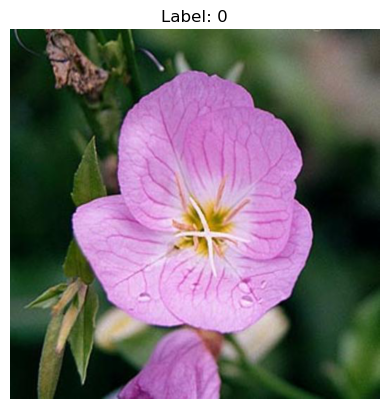

In [24]:
import matplotlib.pyplot as plt
import torch

# 给定的张量和标签
tensor_data, label = test_dataset[0]

# 将张量数据从[-1, 1]范围转换到[0, 1]范围
tensor_data = (tensor_data + 1) / 2

# 将tensor转换为numpy数组，并交换通道以适应matplotlib的格式
image_data = tensor_data.permute(1, 2, 0).numpy()

# 显示图像
plt.imshow(image_data)
plt.title(f"Label: {label}")
plt.axis('off')  # 关闭坐标轴
plt.show()

In [25]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

def create_data_loaders(args, labeled_dataset, unlabeled_dataset, test_dataset):
    train_sampler = RandomSampler if args["local_rank"] == -1 else DistributedSampler

    labeled_trainloader = DataLoader(
        labeled_dataset,
        sampler=train_sampler(labeled_dataset),
        batch_size=args['batch_size'],
        num_workers=args['num_workers'],
        drop_last=True)

    unlabeled_trainloader = DataLoader(
        unlabeled_dataset,
        sampler=train_sampler(unlabeled_dataset),
        batch_size=args['batch_size']*7,
        num_workers=args['num_workers'],
        drop_last=True)

    test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=args['batch_size'],
        num_workers=args['num_workers'])

    return labeled_trainloader, unlabeled_trainloader, test_loader

In [26]:
labeled_trainloader, unlabeled_trainloader, test_loader = create_data_loaders(args, train_labeled_dataset, train_unlabeled_dataset, test_dataset)